In [4]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from itertools import cycle

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [5]:
import scrap_data
data_saham = scrap_data.ambil_data("bbri")

data_saham

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2018-06-04,3150.0,3170.0,3100.0,3130.0,2594.125000,211936400,BBRI.JK
2018-06-05,3150.0,3160.0,3090.0,3110.0,2577.549072,135979600,BBRI.JK
2018-06-06,3120.0,3160.0,3090.0,3150.0,2610.701416,99509500,BBRI.JK
2018-06-07,3180.0,3270.0,3160.0,3270.0,2710.156006,183746200,BBRI.JK
2018-06-08,3210.0,3250.0,3110.0,3140.0,2602.412842,262972300,BBRI.JK
...,...,...,...,...,...,...,...
2023-05-25,5500.0,5575.0,5450.0,5475.0,5475.000000,224391900,BBRI.JK
2023-05-26,5425.0,5600.0,5425.0,5600.0,5600.000000,154003100,BBRI.JK
2023-05-29,5600.0,5625.0,5475.0,5550.0,5550.000000,125049100,BBRI.JK


In [6]:

closedf = data_saham.filter(['Close'])


# closedf = data_saham[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1240, 1)


In [7]:
close_stock = closedf.copy()

scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1240, 1)


In [8]:
close_stock

,Close
Date,
2018-06-04,3130.0
2018-06-05,3110.0
2018-06-06,3150.0
2018-06-07,3270.0
2018-06-08,3140.0
...,...
2023-05-25,5475.0
2023-05-26,5600.0
2023-05-29,5550.0


In [9]:
training_size=int(len(closedf)*0.80)-30
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (962, 1)
test_data:  (278, 1)


In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)


X_train:  (931, 30)
y_train:  (931,)
X_test:  (247, 30)
y_test (247,)


In [12]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel= 'rbf', C= 1e2, gamma= 0.1)
svr_rbf.fit(X_train, y_train)

SVR(C=100.0, gamma=0.1)

In [13]:
# Lets Do the prediction 

train_predict=svr_rbf.predict(X_train)
test_predict=svr_rbf.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (931, 1)
Test data prediction: (247, 1)


In [14]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

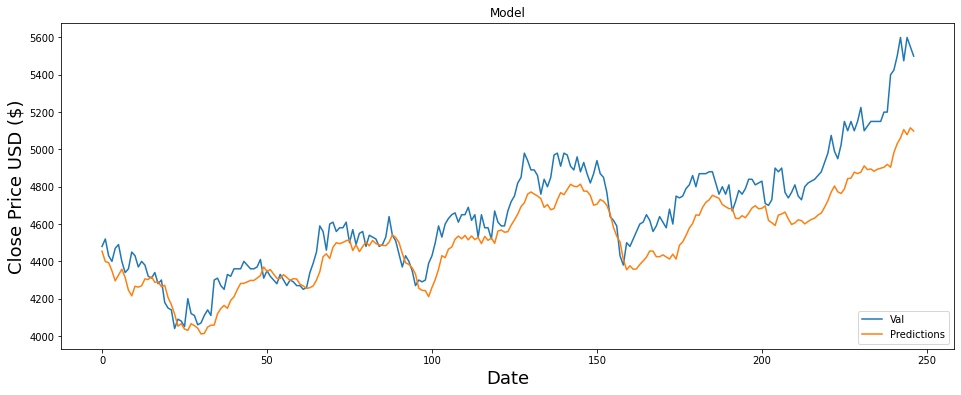

In [15]:
# Plot the data
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

plt.plot(original_ytest)

plt.plot(test_predict)
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

In [17]:
# Step 6: Make predictions for the next 7 days
last_sequence = test_data[-time_step:]  # Last sequence from the testing data

predicted_prices = []
 
harga_kedepan = []

banyak_prediksi= 7
for _ in range(banyak_prediksi):
    next_price = svr_rbf.predict(last_sequence.reshape(1, time_step))
    predicted_prices.append(next_price)
    last_sequence = np.append(last_sequence[1:], next_price)



# Inverse transform the predicted prices to the original scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Print the predicted prices for the next 7 days
# print("Predicted Prices for the Next 7 Days:")
# for price in predicted_prices:
#     print(price[0])

for price in predicted_prices:
    harga_pred = price[0]
    harga_kedepan.append(harga_pred)

print(harga_kedepan)

[5086.2742360872335, 4928.527814667954, 4823.153314488977, 4700.6717078614565, 4615.990357244409, 4537.250846070246, 4446.931821171653]


In [ ]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVR


def prediksi_svr(df,lama_pred):
    closedf = df.filter(['Close'])

    scaler=MinMaxScaler(feature_range=(0,1))
    closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
    training_size=int(len(closedf)*0.80)-30
    test_size=len(closedf)-training_size
    train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
    # convert an array of values into a dataset matrix
    def create_dataset(dataset, time_step):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), np.array(dataY)
    
    time_step = 30
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)



    svr_rbf = SVR(kernel= 'rbf', C= 1e2, gamma= 0.1)
    svr_rbf.fit(X_train, y_train)

    # Lets Do the prediction 

    train_predict=svr_rbf.predict(X_train)
    test_predict=svr_rbf.predict(X_test)

    train_predict = train_predict.reshape(-1,1)
    test_predict = test_predict.reshape(-1,1)


    # Transform back to original form

    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
    original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 
    # Step 6: Make predictions for the next 7 days
    last_sequence = test_data[-time_step:]  # Last sequence from the testing data

    predicted_prices = []

    harga_kedepan = []

    banyak_prediksi= lama_pred
    for _ in range(banyak_prediksi):
        next_price = svr_rbf.predict(last_sequence.reshape(1, time_step))
        predicted_prices.append(next_price)
        last_sequence = np.append(last_sequence[1:], next_price)



    # Inverse transform the predicted prices to the original scale
    predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

    # Print the predicted prices for the next 7 days
    # print("Predicted Prices for the Next 7 Days:")
    # for price in predicted_prices:
    #     print(price[0])

    for price in predicted_prices:
        harga_pred = price[0]
        harga_kedepan.append(harga_pred)


    return(harga_kedepan,test_predict)






